## Bayesian AGN Decomposition Analysis for SDSS Spectra (BADASS)
### Non-SDSS Single Spectrum - IRTF spectrum Example downloaded from NED

####  Remington O. Sexton$^{1,2}$, Sara M. Doan$^{1}$, Michael A. Reefe$^{1}$, William Matzko$^{1}$
$^{1}$George Mason University, $^{2}$United States Naval Observatory,

In [1]:
import glob
import time
import natsort
from IPython.display import clear_output
# import multiprocess as mp
import os
import psutil
import pathlib
# Import BADASS here
import badass as badass
import badass_utils as badass_utils

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### BADASS Options

In [2]:
################################## Fit Options #################################
# Fitting Parameters
fit_options={
"fit_reg"    : (9700,10500), # Fitting region; Note: Indo-US Library=(3460,9464)
"good_thresh": 0.0, # percentage of "good" pixels required in fig_reg for fit.
"mask_bad_pix": False, # mask pixels SDSS flagged as 'bad' (careful!)
"mask_emline" : False, # automatically mask lines for continuum fitting.
"mask_metal": False, # interpolate over metal absorption lines for high-z spectra
"fit_stat": "RCHI2", # fit statistic; ML = Max. Like. , OLS = Ordinary Least Squares, RCHI2 = reduced chi2
"n_basinhop": 10, # Number of consecutive basinhopping thresholds before solution achieved
"test_outflows": False, # only test for outflows; "fit_outflows" must be set to True!
"test_line": {"bool":False,
              "line":"NA_OIII_5007"},
"max_like_niter": 0, # number of maximum likelihood iterations
"output_pars": False, # only output free parameters of fit and stop code (diagnostic)
"cosmology": {"H0":70.0, "Om0": 0.30}, # Flat Lam-CDM Cosmology
}
################################################################################

########################### MCMC algorithm parameters ##########################
mcmc_options={
"mcmc_fit"    : False, # Perform robust fitting using emcee
"nwalkers"    : 100,  # Number of emcee walkers; min = 2 x N_parameters
"auto_stop"   : False, # Automatic stop using autocorrelation analysis
"conv_type"   : "all", # "median", "mean", "all", or (tuple) of parameters
"min_samp"    : 1000,  # min number of iterations for sampling post-convergence
"ncor_times"  : 1.0,  # number of autocorrelation times for convergence
"autocorr_tol": 10.0,  # percent tolerance between checking autocorr. times
"write_iter"  : 100,   # write/check autocorrelation times interval
"write_thresh": 100,   # iteration to start writing/checking parameters
"burn_in"     : 1500, # burn-in if max_iter is reached
"min_iter"    : 2500, # min number of iterations before stopping
"max_iter"    : 2500, # max number of MCMC iterations
}
################################################################################

############################ Fit component op dtions #############################
comp_options={
"fit_opt_feii"     : False, # optical FeII
"fit_uv_iron"      : False, # UV Iron 
"fit_balmer"       : False, # Balmer continuum (<4000 A)
"fit_losvd"        : False, # stellar LOSVD
"fit_host"         : False, # host template
"fit_power"        : False, # AGN power-law
"fit_poly"         : True, # Add polynomial continuum component
"fit_narrow"       : True, # narrow lines
"fit_broad"        : True, # broad lines
"fit_outflow"      : False, # outflow lines
"fit_absorp"       : False, # absorption lines
"tie_line_fwhm"    : True, # tie line widths
"tie_line_voff"    : True, # tie line velocity offsets
"na_line_profile"  : "GH",     # narrow line profile
"br_line_profile"  : "V",     # broad line profile
"out_line_profile" : "G",     # outflow line profile
"abs_line_profile" : "G",     # absorption line profile
"n_moments"        : 6, # number of Gauss-Hermite moments for Gauss-Hermite line profiles
                        # must be >2 and <10 for higher-order moments (default = 4)
}
################################################################################

########################### Emission Lines & Options ###########################
# If not specified, defaults to SDSS-QSO Emission Lines (http://classic.sdss.org/dr6/algorithms/linestable.html)
################################################################################
user_lines = {
# "na_unknown_1":{"center":5007., "line_type":"user", "line_profile":"g"},
}
user_constraints = [
#     ("br_MgII_2799_2_amp","br_MgII_2799_amp"),
]
# User defined masked regions (list of tuples)
user_mask = [
# (4750,5100),
# (5100,5200),
# (3250,3600),
]

combined_lines = {
"OIII_5007_COMP":["NA_OIII_5007","OUT_OIII_5007"],
"OIII_4960_COMP":["NA_OIII_4960","OUT_OIII_4960"],
"H_BETA_COMP"   :["NA_H_BETA","OUT_H_BETA"],
}
########################## LOSVD Fitting & Options ##################
# For direct fitting of the stellar kinematics (stellar LOSVD), one can 
# specify a stellar template library (Indo-US, Vazdekis 2010, or eMILES).
# One can also hold velocity or dispersion constant to avoid template
# convolution during the fitting process.
################################################################################

losvd_options = {
"library"   : "IndoUS", # Options: IndoUS, Vazdekis2010, eMILES
"vel_const" : {"bool":False, "val":0.0},
"disp_const": {"bool":False, "val":250.0},
"losvd_apoly": {"bool":False , "order":3},
}

########################## SSP Host Galaxy Template & Options ##################
# The default is zero velocity, 100 km/s dispersion 10 Gyr template from 
# the eMILES stellar library. 
################################################################################

host_options = {
"age"       : [0.1,1.0,5.0,10.0], # Gyr; [0.09 Gyr - 14 Gyr] 
"vel_const" : {"bool":False, "val":0.0},
"disp_const": {"bool":False, "val":150.0}
}

########################### AGN power-law continuum & Options ##################
# The default is a simple power law.
################################################################################

power_options = {
"type" : "simple" # alternatively, "broken" for smoothly-broken power-law
}

########################### Polynomial Continuum Options #######################
# Disabled by default.  Options for a power series polynomial continuum, 
# additive legendre polynomial, or multiplicative polynomial to be included in 
# the fit.
################################################################################

poly_options = {
"ppoly" : {"bool": True, "order": 5}, # positive definite additive polynomial 
"apoly" : {"bool": False , "order": 3}, # Legendre additive polynomial 
"mpoly" : {"bool": False, "order": 3}, # Legendre multiplicative polynomial 
}

############################### Optical FeII options ###############################
# Below are options for fitting FeII.  For most objects, you don't need to 
# perform detailed fitting on FeII (only fit for amplitudes) use the 
# Veron-Cetty 2004 template ('VC04') (2-6 free parameters)
# However in NLS1 objects, FeII is much stronger, and sometimes more detailed 
# fitting is necessary, use the Kovacevic 2010 template 
# ('K10'; 7 free parameters).

# The options are:
# template   : VC04 (Veron-Cetty 2004) or K10 (Kovacevic 2010)
# amp_const  : constant amplitude (default False)
# fwhm_const : constant fwhm (default True)
# voff_const : constant velocity offset (default True)
# temp_const : constant temp ('K10' only)

opt_feii_options={
"opt_template"  :{"type":"VC04"}, 
"opt_amp_const" :{"bool":False, "br_opt_feii_val":1.0   , "na_opt_feii_val":1.0},
"opt_fwhm_const":{"bool":False, "br_opt_feii_val":3000.0, "na_opt_feii_val":500.0},
"opt_voff_const":{"bool":False, "br_opt_feii_val":0.0   , "na_opt_feii_val":0.0},
}
# or
# opt_feii_options={
# "opt_template"  :{"type":"K10"},
# "opt_amp_const" :{"bool":False,"f_feii_val":1.0,"s_feii_val":1.0,"g_feii_val":1.0,"z_feii_val":1.0},
# "opt_fwhm_const":{"bool":False,"opt_feii_val":1500.0},
# "opt_voff_const":{"bool":False,"opt_feii_val":0.0},
# "opt_temp_const":{"bool":True,"opt_feii_val":10000.0},
# }
################################################################################

############################### UV Iron options ################################
uv_iron_options={
"uv_amp_const"  :{"bool":False, "uv_iron_val":1.0},
"uv_fwhm_const" :{"bool":False, "uv_iron_val":3000.0},
"uv_voff_const" :{"bool":True,  "uv_iron_val":0.0},
"uv_legendre_p" :{"bool":False, "uv_iron_val":3},
}
################################################################################

########################### Balmer Continuum options ###########################
# For most purposes, only the ratio R, and the overall amplitude are free paramters
# but if you want to go crazy, you can fit everything.
balmer_options = {
"R_const"          :{"bool":True,  "R_val":1.0}, # ratio between balmer continuum and higher-order balmer lines
"balmer_amp_const" :{"bool":False, "balmer_amp_val":1.0}, # amplitude of overall balmer model (continuum + higher-order lines)
"balmer_fwhm_const":{"bool":True,  "balmer_fwhm_val":5000.0}, # broadening of higher-order Balmer lines
"balmer_voff_const":{"bool":True,  "balmer_voff_val":0.0}, # velocity offset of higher-order Balmer lines
"Teff_const"       :{"bool":True,  "Teff_val":15000.0}, # effective temperature
"tau_const"        :{"bool":True,  "tau_val":1.0}, # optical depth
}

################################################################################

############################### Plotting options ###############################
plot_options={
"plot_param_hist"    : True,# Plot MCMC histograms and chains for each parameter
"plot_flux_hist"     : False,# Plot MCMC hist. and chains for component fluxes
"plot_lum_hist"      : False,# Plot MCMC hist. and chains for component luminosities
"plot_eqwidth_hist"  : False, # Plot MCMC hist. and chains for equivalent widths 
"plot_HTML"          : True,# make interactive plotly HTML best-fit plot
}
################################################################################

################################ Output options ################################
output_options={
"write_chain" : False, # Write MCMC chains for all paramters, fluxes, and
                         # luminosities to a FITS table We set this to false 
                         # because MCMC_chains.FITS file can become very large, 
                         # especially  if you are running multiple objects.  
                         # You only need this if you want to reconstruct chains 
                         # and histograms. 
"verbose"     : True,  # prints steps of fitting process in Notebook
}
################################################################################

### Run BADASS on a single spectrum

The following is shows how to fit single SDSS spectra.

#### Directory Structure

In [3]:
########################## Directory Structure #################################
spec_dir = 'examples/' # folder with spectra in it
# Get full list of spectrum folders; these will be the working directories
spec_loc = natsort.natsorted( glob.glob(spec_dir+'I*') )
################################################################################
print(spec_loc)

['examples/IRTF']


#### Choose Spectrum

In [4]:
nobj = 0 # Object in the spec_loc list
work_dir = spec_loc[nobj]+'/' # working directory
# Set up run ('MCMC_output_#') directory
file = glob.glob(work_dir+'*.fits')[0] # Get name of FITS spectra file
#
print(file)

examples/IRTF/spec-IRTF-3.2m-Mid-IR.fits


#### Load the Spectrum 

0.017559
15.6
[5.0874023 5.0878906 5.0878906 ... 5.0878906 5.0878906 5.0878906]


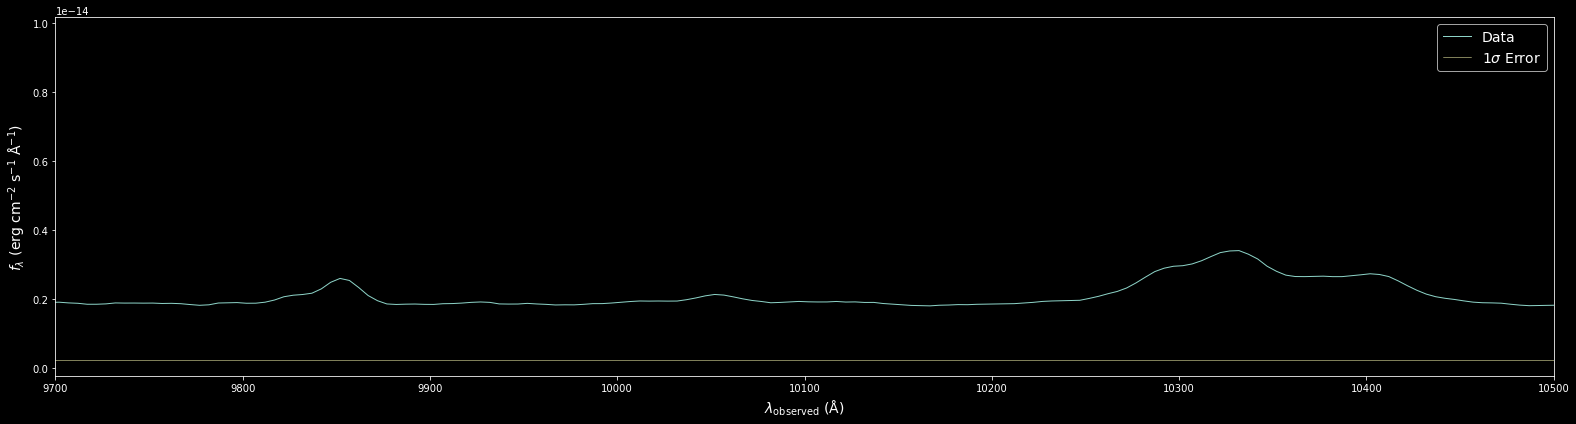

In [5]:
# For non-SDSS spectra, you must explicitly pass vectors for the spectrum (spec), 
# linearly-binned wavelength (wave), error spectrum (err), FWHM resolution in Å (fwhm),
# redshift (z), and Galactic reddening E(B-V) (ebv).
from astropy.io import fits
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

hdulist = fits.open(file)
header = hdulist[0].header
cols = hdulist[1].columns.names
z = header['z']
fwhm = header['FWHM_RES']
print(z)
print(fwhm)
spec = hdulist[1].data["FLUX"]/1.e+17
wave = hdulist[1].data["WAVE"]
err = np.full_like(spec,np.nanstd(spec-gaussian_filter1d(spec,10)))
ebv = 0.01
print(np.diff(wave))


# Plot
fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(wave/(1+z),spec,linewidth=1,label=r'Data')
ax1.plot(wave/(1+z),err,linewidth=0.5,label=r'$1\sigma$ Error')
fontsize=14

ax1.set_xlabel(r"$\lambda_{\rm{observed}}$ ($\rm{\AA}$)",fontsize=fontsize)
ax1.set_ylabel(r"$f_\lambda$ (erg cm$^{-2}$ s$^{-1}$ $\rm{\AA}^{-1}$)",fontsize=fontsize)
ax1.set_xlim(fit_options["fit_reg"][0],fit_options["fit_reg"][1])
ax1.legend(fontsize=fontsize)
plt.tight_layout()

### Run 

In [ ]:
# Note: we set sdss_spec=False for non-SDSS spectrum.  This tells BADASS
# to use the spec, wave, err, fwhm, z, and ebv keywords for the data input.

# Call the main function in BADASS
badass.run_BADASS(pathlib.Path(file),
                  fit_options          = fit_options,
                  mcmc_options         = mcmc_options,
                  comp_options         = comp_options,
                  user_lines           = user_lines, # User-lines
                  user_constraints     = user_constraints, # User-constraints
                  user_mask            = user_mask, # User-mask
                  combined_lines       = combined_lines,
                  losvd_options        = losvd_options,
                  host_options         = host_options,
                  power_options        = power_options,
                  poly_options         = poly_options,
                  opt_feii_options     = opt_feii_options,
                  uv_iron_options      = uv_iron_options,
                  balmer_options       = balmer_options,
                  plot_options         = plot_options,
                  output_options       = output_options,
                  # Here is where we specify that we are fitting a non-SDSS user-input spectrum:
                  sdss_spec            = False,
                  spec                 = spec,
                  wave                 = wave, # observed wavelength
                  err                  = err, # 1-sigma uncertainty
                  fwhm                 = fwhm, # linear FWHM resolution in Angstroms
                  z                    = z, # BADASS assumes spectrum is NOT corrected for redshift.
                  ebv                  = ebv # for Galactic extinction correction.
                 )
    #

Start process memory: 0.51874202                    
 Storing MCMC_output in examples/IRTF/MCMC_output_2/

 > Starting fit for IRTF

 Input spectrum is not linearly binned. BADASS will linearly rebin and conserve flux...


-----------------------------------------------------------
 file:                        spec-IRTF-3.2m-Mid-IR.fits    
 redshift:                    0.01756                       
 fitting region:              (9700,10500) [A]              
 velocity scale:              103.38 [km/s/pixel]           
 Galactic E(B-V):             0.010                         
-----------------------------------------------------------

 Initializing parameters for Maximum Likelihood Fitting.
----------------------------------------------------------------------------------------------------
	 - Adding parameter for unexplained noise to fit reduced Chi-squared.
  - Fitting polynomial continuum component.

 - ('BR_H_BETA_FWHM', 'NA_OIII_5007_FWHM') soft constraint removed because on

basinhopping step 0: f 737.316
basinhopping step 1: f 584.57 trial_f 584.57 accepted 1  lowest_f 584.57
found new global minimum on step 1 with function value 584.57
basinhopping step 2: f 573.454 trial_f 573.454 accepted 1  lowest_f 573.454
found new global minimum on step 2 with function value 573.454
basinhopping step 3: f 573.354 trial_f 573.354 accepted 1  lowest_f 573.354
found new global minimum on step 3 with function value 573.354
basinhopping step 4: f 573.425 trial_f 573.425 accepted 1  lowest_f 573.354
basinhopping step 5: f 573.425 trial_f 1.73152e+09 accepted 0  lowest_f 573.354
basinhopping step 6: f 573.425 trial_f 580.557 accepted 0  lowest_f 573.354
basinhopping step 7: f 573.424 trial_f 573.424 accepted 1  lowest_f 573.354
basinhopping step 8: f 573.424 trial_f 573.424 accepted 1  lowest_f 573.354
basinhopping step 9: f 573.424 trial_f 7.67503e+09 accepted 0  lowest_f 573.354
basinhopping step 10: f 573.424 trial_f 573.424 accepted 1  lowest_f 573.354
basinhopping st